# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercício é treinar e avaliar um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X.

As métricas a serem reportadas são F1 e Equal Error Rate (ERR) e seu respectivo threshold.

Note que uma das dificuldades deste exercicio será processar as imagens, que tem 1100 x 1100 pixels.

Dica: Utilize o [pyeer](https://pypi.org/project/pyeer/) para plotar o EER.

Planejamento / ideias iniciais

 - Parte dos dados parece ser crítica, fazer ela primeiro
 - Deixar tudo organizado e modular, pra faciltiar teste de novos modelos
 - Testar fluxo geral com coisas simples
 - experimento bem organizado inicialmente vai ajudar a economizar tempo no final
 - encapsular data no datamodule
 - deixar a classe lightning flexíel pra conseguir testar diferentes arquiteturas se quiser

Para facilitar a organização dos experimentos e deixar o código agnóstico a onde estiver rodando (Colab vs máquina local), vou organizar o código pra com scripts via terminal, usando as funcionalidade que o Lightning têm para facilitar isso ([aqui](https://pytorch-lightning.readthedocs.io/en/1.2.4/common/hyperparameters.html#argumentparser) tem uma explicação boa).

Vamos começar testando algo simples, Efficient Net vanilla sem usar data augmentation.

# Instalação de pacotes e imports gerais

In [ ]:
!sudo apt-get install tree
!pip3 install -q neptune-client torchviz pytorch-lightning torchmetrics torchinfo efficientnet_pytorch lightning-bolts

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (915 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: 

In [ ]:

%load_ext autoreload
%autoreload 2

import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4N2Q2ZmI0OS04ZTAyLTRhOGMtYjExYi0zMzUwNzFmZmQzZWQifQ=='
# os.environ['NEPTUNE_API_TOKEN'] = 'Favor não usar por engano'
# Deixa tudo replicável
import pytorch_lightning as pl
pl.seed_everything(123)


Global seed set to 123


123

Check de GPU:

In [ ]:
!nvidia-smi

Thu May 13 11:07:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

Define código de conversão dos arquivos hdfs para estrutura ImageFolder:

In [ ]:
%%writefile convert_hdf5_to_image_folder.py
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from tqdm import tqdm
import h5py
import math
import numpy as np
import os


def prepare_image_folder(hdf5_input, output_dir):
    """Converts hdf5 to Pytorch ImageFolder directory tree structure.

    Args:
        hdf5_input (str): path to hdf5 original input file
        output_dir (str): base output dir

    """

    os.makedirs(output_dir, exist_ok=False)

    tqdm_desc = 'Creating ImageFolder structure from  {} to {}'.format(
        hdf5_input, output_dir)
    with h5py.File(hdf5_input, 'r') as h5file:
        assert h5file.keys() == {'data', 'label'}
        total = h5file['label'].shape[0]
        assert total == h5file['data'].shape[0]

        # filename will be filled with zeros to enable lexicographic sort
        idx_digits = math.ceil(math.log10(total))

        for idx in tqdm(range(total), desc=tqdm_desc):
            label = str(h5file['label'][idx])
            os.makedirs(os.path.join(output_dir, label), exist_ok=True)
            np_file_out = os.path.join(
                output_dir, label, f'image_{str(idx).zfill(idx_digits)}.npy')
            img = h5file['data'][idx].copy()
            # Dica da normalizacão do nosso amigo Orlem
            img = img = ((img / np.max(img)) * 255).astype(np.uint8)
            np.save(np_file_out, img)


if __name__ == '__main__':
    parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
    parser.add_argument('--hdf5_input',
                        type=str,
                        required=True,
                        help='hdf5 input file')
    parser.add_argument('--output_dir',
                        type=str,
                        required=True,
                        help='Output base directory')
    args = parser.parse_args()
    prepare_image_folder(args.hdf5_input, args.output_dir)


Writing convert_hdf5_to_image_folder.py


Define código de download conversão para estrutura de ImageFolder:

In [ ]:
%%writefile prepare_data.sh

mkdir -p ./data/hdf5_original_files
gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* ./data/hdf5_original_files

python3 convert_hdf5_to_image_folder.py --hdf5_input=./data/hdf5_original_files/train.hdf5 --output_dir=./data/image_folders/train &
python3 convert_hdf5_to_image_folder.py --hdf5_input=./data/hdf5_original_files/valid.hdf5 --output_dir=./data/image_folders/valid &
python3 convert_hdf5_to_image_folder.py --hdf5_input=./data/hdf5_original_files/test.hdf5 --output_dir=./data/image_folders/test &
wait

Writing prepare_data.sh


Roda código de download e conversão para estrutura de ImageFolder (demora ~ 10 min):

In [ ]:
%%time
!chmod 766 ./prepare_data.sh && ./prepare_data.sh

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/train.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/valid.hdf5...
/ [3/3 files][ 11.3 GiB/ 11.3 GiB] 100% Done  49.2 MiB/s ETA 00:00:00           
Operation completed over 3 objects/11.3 GiB.                                     
Creating ImageFolder structure from  ./data/hdf5_original_files/valid.hdf5 to ./data/image_folders/valid: 100% 1000/1000 [03:19<00:00,  5.01it/s]
Creating ImageFolder structure from  ./data/hdf5_original_files/test.hdf5 to ./data/image_folders/test: 100% 1000/1000 [03:21<00:00,  4.97it/s]
Creating ImageFolder structure from  ./data/hdf5_original_files/train.hdf5 to ./data/image_folders/train: 100% 3000/3000 [05:37<00:00,  8.89it/s]
CPU times: user 7.74 s, sys: 1.51 s, total: 9.25 s
Wall time: 10min 19s


Como as pastas ficam organizadas:

In [ ]:
!ls -lht data

total 8.0K
drwxr-xr-x 5 root root 4.0K May 13 11:12 image_folders
drwxr-xr-x 2 root root 4.0K May 13 11:12 hdf5_original_files


In [ ]:
!ls -lht ./data/image_folders

total 12K
drwxr-xr-x 4 root root 4.0K May 13 11:12 train
drwxr-xr-x 4 root root 4.0K May 13 11:12 test
drwxr-xr-x 4 root root 4.0K May 13 11:12 valid


In [ ]:
!ls -lht ./data/image_folders/train

total 116K
drwxr-xr-x 2 root root 40K May 13 11:18 1
drwxr-xr-x 2 root root 68K May 13 11:18 0


In [ ]:
!tree -l ./data/image_folders/train | head

./data/image_folders/train
├── 0
│   ├── image_0000.npy
│   ├── image_0001.npy
│   ├── image_0002.npy
│   ├── image_0004.npy
│   ├── image_0005.npy
│   ├── image_0006.npy
│   ├── image_0007.npy
│   ├── image_0008.npy


# Treinamento do modelo

Definindo nosso script principal de treino:

In [ ]:
%%writefile trainer_v3.py

"""
Versão limpa para entrega.
"""

from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser, Namespace
from efficientnet_pytorch import EfficientNet
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
import efficientnet_pytorch
import multiprocessing as mp
import numpy as np
import os
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torchmetrics
import torchvision
import uuid

pl.seed_everything(123)


# Datamodule for EfficientNet Model
class EfficientDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_batch_size=50,
                 eval_batch_size=50,
                 model_name='efficientnet-b0',
                 advprop=False,
                 aug_transform=None,
                 imagefolders_basedir='data/image_folders/'):
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.imagefolders_basedir = imagefolders_basedir

        assert model_name in efficientnet_pytorch.VALID_MODELS
        self.model_name = model_name

        self.advprop = advprop
        self.aug_transform = aug_transform

    def setup(self, stage):
        last_transform = EfficientDataModule.normalize_resize_transforms(
            self.model_name)
        if self.aug_transform is None:
            self.train_transform = self.eval_transform = last_transform
        else:
            self.eval_transform = last_transform
            self.train_transform = torchvision.transforms.Compose(
                [self.aug_transform, last_transform])

        if stage == 'fit':
            self.train_dataset = DatasetFolder(
                os.path.join(self.imagefolders_basedir, 'train'),
                loader=np.load,
                extensions='.npy',
                transform=self.train_transform,
                target_transform=lambda x: torch.tensor(x))
            self.val_dataset = DatasetFolder(
                os.path.join(self.imagefolders_basedir, 'valid'),
                loader=np.load,
                extensions='.npy',
                transform=self.eval_transform,
                target_transform=lambda x: torch.tensor(x))
        elif stage == 'test':
            self.test_dataset = DatasetFolder(
                os.path.join(self.imagefolders_basedir, 'test'),
                loader=np.load,
                extensions='.npy',
                transform=self.eval_transform,
                target_transform=lambda x: torch.tensor(x))
        else:
            raise ValueError("Stage must be 'fit' or 'test'.")

    @staticmethod
    def normalize_resize_transforms(model_name: str, advprop: bool = False):
        '''Final layer of transforms for EfficientNet'''
        image_size = EfficientNet.get_image_size(model_name)
        image_size = (image_size, image_size)
        if advprop:
            norm_transform = torchvision.transforms.Lambda(
                lambda img: img * 2.0 - 1.0)
        else:
            norm_transform = torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        out = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.Lambda(lambda x: x.tile(3, 1, 1)),
            norm_transform
        ])
        return out

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.train_batch_size,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=mp.cpu_count())

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.eval_batch_size,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=mp.cpu_count())

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.eval_batch_size,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=mp.cpu_count())

    @staticmethod
    def add_specific_args(parent_parser):
        # advprop e model_name vem do módulo principal do Lightning
        parser = parent_parser.add_argument_group('DataModule')
        parser.add_argument('--train_batch_size',
                            type=int,
                            default=50,
                            help='Train batch size.')
        parser.add_argument('--eval_batch_size',
                            type=int,
                            default=50,
                            help='Validation/Test batch size.')
        parser.add_argument('--imagefolders_basedir',
                            type=str,
                            default='data/image_folders',
                            help='Base directory for image folders.')
        return parent_parser


def prefix_or_postfix_dict_keys(d, prefix='', postfix=''):
    '''Adds prefix and post fix to dict key. Keys must be strings.'''
    assert all(isinstance(k, str) for k in d.keys())
    return {f'{prefix}{str(k)}{postfix}': v for k, v in d.items()}


# Main lightning module
class LitCovidClassifier(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        # self.hparams = hparams
        self.save_hyperparameters(hparams)
        self.model = EfficientNet.from_pretrained(
            model_name=self.hparams.model_name,
            advprop=self.hparams.advprop,
            num_classes=1)

        # self.threshold_select_mode = self.hparams.threshold_select_mode
        self.threshold = hparams.threshold

    def get_metrics(self, threshold=0.5, prefix=None, postfix=None):
        kwargs = dict(threshold=threshold, compute_on_step=True)
        metrics = torchmetrics.MetricCollection(
            {
                'accuracy': torchmetrics.Accuracy(**kwargs),
                'f1': torchmetrics.F1(**kwargs),
                'precision': torchmetrics.Precision(**kwargs),
                'recall': torchmetrics.Recall(**kwargs)
            },
            prefix=prefix,
            postfix=postfix)
        return metrics

    def forward(self, x):
        """Inference step"""
        # in lightning, forward defines the prediction/inference actions
        logits = self.model(x).ravel()
        probs = logits.sigmoid()
        return logits, probs

    def training_step(self, batch, batch_idx):
        x, y = batch
        # y has size (B,) because we used a single-element tensor
        # model(x) has size (B,1)
        logits = self.model(x).ravel()
        probs = logits.sigmoid()

        batch_loss = F.binary_cross_entropy_with_logits(logits, y.float())

        # update state and calculate for current batch - arrumar
        batch_metrics = self.get_metrics(self.threshold, prefix='train_batch_')
        batch_metrics = batch_metrics.to(probs.device)(probs, y)

        self.log_dict(batch_metrics,
                      prog_bar=False,
                      logger=True,
                      on_step=True,
                      on_epoch=False)

        self.log('train_loss',
                 batch_loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True)
        return {
            'loss': batch_loss,
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        }

    def base_eval_step(self, batch, batch_idx):
        """Accumulate scores and targets."""
        x, y = batch
        logits, probs = self.forward(x)
        return {'probs': probs.detach().cpu(), 'targets': y.detach().cpu()}

    def concat_by_key(self, list_of_dicts, key):
        out = torch.cat([x[key] for x in list_of_dicts])
        return out

    def base_epoch_end(self, outputs, part):
        """Reduce metrics over epoch."""
        probs = self.concat_by_key(outputs, 'probs')
        targets = self.concat_by_key(outputs, 'targets')

        # cm = confusion_matrix_precision_recall_curve(targets.numpy(),
        #                                              probs.numpy())
        # idx_err = np.abs(cm['frr'] - cm['far']).argmin()
        # precisa arrumar esse pra pegar o primeiro threshold abaixo
        # cm_at = {k: v[idx_err] for k, v in cm.items()}

        # if part == 'val':
        #     self.threshold = cm_at['thresholds']
        epoch_metrics = self.get_metrics(threshold=self.threshold,
                                         prefix=f'{part}_epoch_')(probs,
                                                                  targets)

        # cm_at = prefix_or_postfix_dict_keys(cm_at, prefix='cm_')
        # self.log_dict(cm_at, prog_bar=False, logger=True)
        self.log_dict(epoch_metrics, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        return self.base_eval_step(batch, batch_idx)

    def test_step(self, batch, batch_idx):
        return self.base_eval_step(batch, batch_idx)

    def training_epoch_end(self, outputs):
        self.base_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.base_epoch_end(outputs, 'val')

    def test_epoch_end(self, outputs):
        self.base_epoch_end(outputs, 'test')

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(),
                                     lr=self.hparams.learning_rate)
        # Aqui usamos um scheduler dummy pois o pytorch lightning original
        # requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimizer, lr_lambda=lambda epoch: 1.0)
        # Forma de retorno para associar um otimizador a um scheduler.
        return [optimizer], [scheduler]

    @staticmethod
    def add_specific_args(parent_parser):
        parser = parent_parser.add_argument_group('Model')
        parser.add_argument('--learning_rate', type=float, default=1e-3)
        parser.add_argument('--advprop',
                            action='store_true',
                            help='If advprop should be used.')
        valid_models = efficientnet_pytorch.VALID_MODELS
        parser.add_argument(
            '--model_name',
            type=str,
            # required=False,
            default='',
            choices=valid_models,
            help='Model name for EfficientNet. Leave blank for testing.')
        parser.add_argument('--threshold',
                            type=float,
                            default=0.5,
                            help='Threshold for positive prediction.')
        return parent_parser


def train(args):
    dm = EfficientDataModule.from_argparse_args(args)
    dm.prepare_data()
    dm.setup('fit')

    model = LitCovidClassifier(args)  # all args will be logged!

    exp_uuid = str(uuid.uuid4())  # avoid conflicts with chechpoints
    neptune_logger = pl.loggers.NeptuneLogger(
        project_name='marcospiau/ia376i-1s2021-aula-07',
        tags=args.tags.split(',') if args.tags else [],
        properties={'exp_uuid': exp_uuid})
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='./checkpoints',
        filename=f'exp_uuid={exp_uuid}-'
        '{epoch}-{train_epoch_f1:.4f}-{train_epoch_accuracy:.4f}-'
        '{val_epoch_f1:.4f}-{val_epoch_accuracy:.4f}',
        monitor='val_epoch_accuracy',
        mode='max',
        save_top_k=1,
        verbose=True,
        save_weights_only=True)
    trainer = pl.Trainer.from_argparse_args(
        args,
        gpus=1,
        # log_gpu_memory=True,
        profiler=False,
        progress_bar_refresh_rate=1,
        callbacks=[checkpoint_callback],
        logger=neptune_logger,
        flush_logs_every_n_steps=5,
        log_every_n_steps=1)

    # trainer.fit(model=model, datamodule=dm) # teardown error
    trainer.fit(model=model,
                train_dataloader=dm.train_dataloader(),
                val_dataloaders=dm.val_dataloader())

    # path up to last folder name and basename
    # dont save in fast_dev_run or when not using NeptuneLogger
    if trainer.checkpoint_callback.best_model_path and isinstance(
            trainer.logger, pl.loggers.NeptuneLogger):
        best_model_path = os.path.join(
            *Path(trainer.checkpoint_callback.best_model_path).parts[-2:])
        trainer.logger.set_property('best_model_path', best_model_path)


def test(checkpoint_path):
    # Load same args from checkpoint
    # TODO: allow updating of some parameters
    checkpoint = torch.load(checkpoint_path)
    checkpoint_args = Namespace(**checkpoint['hyper_parameters'])

    # https://pytorch-lightning.readthedocs.io/en/stable/common/weights_loading.html
    model = LitCovidClassifier(checkpoint_args)
    model.load_state_dict(checkpoint['state_dict'])

    dm = EfficientDataModule.from_argparse_args(checkpoint_args)
    dm.prepare_data()
    dm.setup('test')

    trainer = pl.Trainer(gpus=1)
    trainer.test(model, dm.test_dataloader())


if __name__ == '__main__':
    parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
    parser.add_argument('--tags',
                        type=str,
                        default=None,
                        help='Comma separated tags for NeptuneLogger.')
    parser.add_argument('--test_checkpoint',
                        type=str,
                        default=None,
                        help='Checkpoint for testing. '
                        'If set, all other arguments are ignored!')

    parser = LitCovidClassifier.add_specific_args(parser)
    parser = EfficientDataModule.add_specific_args(parser)
    parser = pl.Trainer.add_argparse_args(parser, use_argument_group=True)
    args = parser.parse_args()

    if args.test_checkpoint:
        test(args.test_checkpoint)
    else:
        train(args)


Writing trainer_v3.py


Como usar o script:

In [ ]:
! python3 trainer_v3.py -h

Global seed set to 123
usage: trainer_v3.py [-h] [--tags TAGS] [--test_checkpoint TEST_CHECKPOINT]
                     [--learning_rate LEARNING_RATE] [--advprop]
                     [--model_name {efficientnet-b0,efficientnet-b1,efficientnet-b2,efficientnet-b3,efficientnet-b4,efficientnet-b5,efficientnet-b6,efficientnet-b7,efficientnet-b8,efficientnet-l2}]
                     [--threshold THRESHOLD]
                     [--train_batch_size TRAIN_BATCH_SIZE]
                     [--eval_batch_size EVAL_BATCH_SIZE]
                     [--imagefolders_basedir IMAGEFOLDERS_BASEDIR]
                     [--logger [LOGGER]]
                     [--checkpoint_callback [CHECKPOINT_CALLBACK]]
                     [--default_root_dir DEFAULT_ROOT_DIR]
                     [--gradient_clip_val GRADIENT_CLIP_VAL]
                     [--gradient_clip_algorithm GRADIENT_CLIP_ALGORITHM]
                     [--process_position PROCESS_POSITION]
                     [--num_nodes NUM_NODES] [--nu

# Breve análise dos dados

In [ ]:
from trainer_v3 import EfficientDataModule
from collections import Counter
import torchvision

Global seed set to 123


Datamodule encapsula toda parte de preparação dos dados, variando a dimensão de output conforme o tamanho de EfficientNet escolhido:

In [ ]:
# Data module default, sem aumento de dados
dm = EfficientDataModule(train_batch_size=10, eval_batch_size=10)
dm.setup('fit')
dm.setup('test')
dm.prepare_data()

Olhada rápida nos datasets e distribuição de dados:

In [ ]:
for dataset, part in zip(
    [dm.train_dataset, dm.val_dataset, dm.test_dataset],
    ['train', 'val', 'test']
    ):
    print(30 * '*' + f' {part} ' + 30 * '*')
    print(dataset)
    counts = Counter(dataset.targets)
    total = sum(counts.values())
    percent = {k:v/total for k, v in counts.items()}
    print(f'counts = {counts}')
    print(f'total = {total}')
    print(f'percent = {percent}')

del total, counts, percent, dataset, part, dm

****************************** train ******************************
Dataset DatasetFolder
    Number of datapoints: 3000
    Root location: data/image_folders/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear)
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: <function EfficientDataModule.setup.<locals>.<lambda> at 0x7f3ce1d20710>
counts = Counter({0: 1773, 1: 1227})
total = 3000
percent = {0: 0.591, 1: 0.409}
****************************** val ******************************
Dataset DatasetFolder
    Number of datapoints: 1000
    Root location: data/image_folders/valid
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear)
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Targ

Os dados estão levemente desbalanceado, com aproximadamente 40% de imagens de COVID.

Fiz alguns testes rápidos com alguns valores diferentes de threshold para predição positiva, mas o que ficou melhor foi de 0.5 (equivalente a usar argmax). Por isso, deixei os testes finais usando esse valor.

Alguns exemplo de imagens (após transformação da para a EfficientNet, com `advprop=False`):

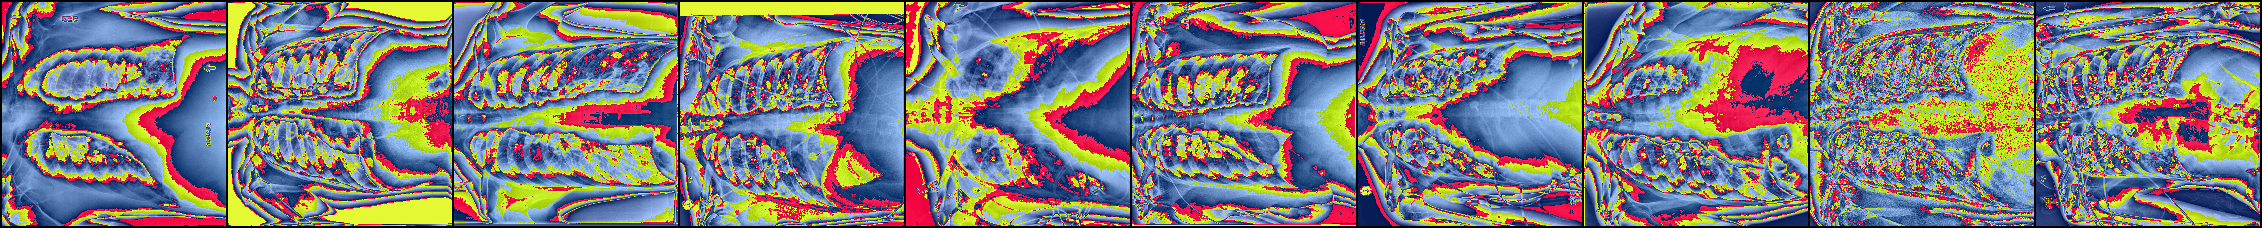

In [ ]:
dm = EfficientDataModule(train_batch_size=10, eval_batch_size=10, advprop=False)
dm.setup('fit')
dm.setup('test')
dm.prepare_data()

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(next(iter(dm.val_dataloader()))[0], nrow=10)
)

Alguns exemplo de imagens (após transformação da para a EfficientNet, com `advprop=True`):

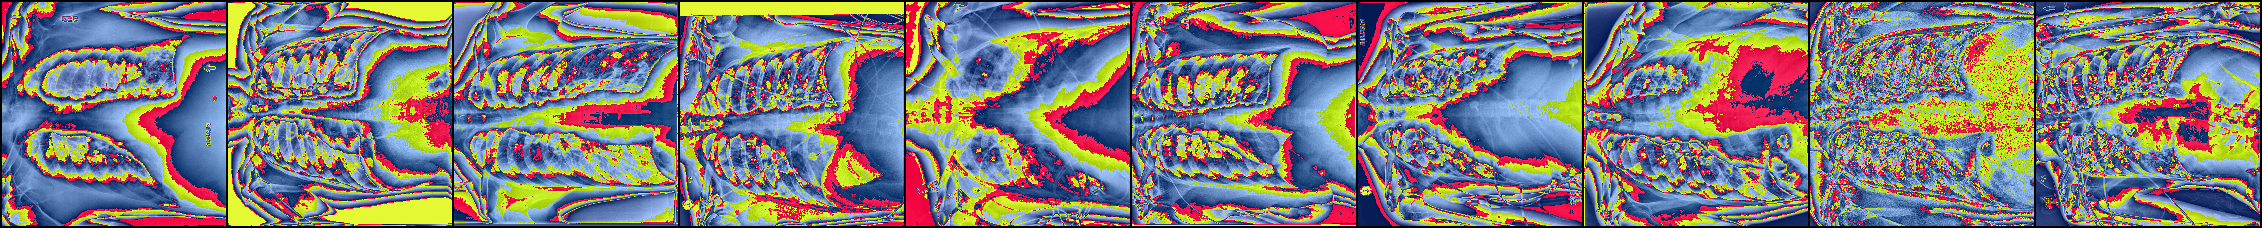

In [ ]:
dm = EfficientDataModule(train_batch_size=10, eval_batch_size=10, advprop=True)
dm.setup('fit')
dm.setup('test')
dm.prepare_data()

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(next(iter(dm.val_dataloader()))[0], nrow=10)
)

# Treinamento

Por comodidade, optei por rodar o treinamento na minha máquina local, utilizando o mesmo código desse notebook. Aqui faremos alguns testes de check no modelo.

Teste de fast_dev_run:

In [ ]:
! python3 trainer.py --model_name='efficientnet-b0'  --train_batch_size=10 --eval_batch_size=10 --fast_dev_run

Global seed set to 123
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100% 20.4M/20.4M [00:00<00:00, 74.1MB/s]
Loaded pretrained weights for efficientnet-b0
NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 4.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
Epoch 0:  50% 1/2 [00:01<00:01,  1.72s/it, loss=0.744, v_num=]
Validating: 0it [00:00, ?it/s]
Validating:   0% 0/1 [00:00<?, ?it/s]
Epoch 0: 100% 2/2 [00:03<00:00,  1.56s/it, loss=0.74

Overfit de um batch de uma amostra:

In [ ]:
%%shell
python3 trainer.py \
    --model_name='efficientnet-b0' \
    --train_batch_size=1 \
    --eval_batch_size=1 \
    --overfit_batches=1 \
    --max_epochs=3 \
    --tags='v3,colab,overfit_one_sample'

Global seed set to 123
Loaded pretrained weights for efficientnet-b0
NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-07/e/IAIS3-70

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 4.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
Validation sanity check: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You requested to overfit but enabled val/test dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)
Global seed set to 123
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You requested to overfit but enable

Overfit batch de 10 amostras:

In [ ]:
%%shell
python3 trainer.py \
    --model_name='efficientnet-b0' \
    --train_batch_size=10 \
    --eval_batch_size=10 \
    --overfit_batches=1 \
    --max_epochs=5 \
    --tags='v3,colab,overfit_batch_10_samples'

Global seed set to 123
Loaded pretrained weights for efficientnet-b0
NeptuneLogger will work in online mode
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory ./checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-07/e/IAIS3-71

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 4.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
Validation sanity check: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You requested to overfit but enabled val/test dataloader shuffling. We are turning it off for you

Exemplo de como rodar o script (esse foi o modeo com o melhor resultado):
```bash
python3 trainer_v3.py \
    --train_batch_size=50 \
    --eval_batch_size=50 \
    --gpus=1  \
    --max_epochs=50  \
    --threshold=0.5 \
    --model_name='efficientnet-b0' \
    --tags='v3,noaug,entrega,advprop' \
    --advprop
```

# Teste no melhor checkpoint de validação

Vamos usar o checkpoint com a melhor acurácia na validação; esse é o resultado reportado na validação.

Checkpoints da rodada final:

In [ ]:
!ls -lht checkpoints

total 32M
-rw-r--r-- 1 root root 16M May 13 02:32 'exp_uuid=cb0956f7-f89c-44f9-95cf-78a3bea3c767-epoch=37-train_epoch_f1=0.9988-train_epoch_accuracy=0.9990-val_epoch_f1=0.9763-val_epoch_accuracy=0.9810.ckpt'
-rw-r--r-- 1 root root 16M May 13 02:31 'exp_uuid=c08aee12-6091-46f7-8f99-3424955f8942-epoch=19-train_epoch_f1=0.9992-train_epoch_accuracy=0.9993-val_epoch_f1=0.9813-val_epoch_accuracy=0.9850.ckpt'


Ordenando pela melhor acurácia de validação (pegamos a primeira linha do checkpoint abaixo):

In [ ]:
! ls checkpoints/exp_uuid\=*  | sort -t= -k4 -r

checkpoints/exp_uuid=c08aee12-6091-46f7-8f99-3424955f8942-epoch=19-train_epoch_f1=0.9992-train_epoch_accuracy=0.9993-val_epoch_f1=0.9813-val_epoch_accuracy=0.9850.ckpt
checkpoints/exp_uuid=cb0956f7-f89c-44f9-95cf-78a3bea3c767-epoch=37-train_epoch_f1=0.9988-train_epoch_accuracy=0.9990-val_epoch_f1=0.9763-val_epoch_accuracy=0.9810.ckpt


Métricas para o teste do melhor checkpoint [experimento IAIS3-77](https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-07/e/IAIS3-77/charts) no Neptune.

Principais hiperparâmetros: `max_epochs=50, lr=1e-3, optimizer=Adam, batch_size=50, advprop=True`

In [ ]:
best_checkpoint_path='checkpoints/exp_uuid=c08aee12-6091-46f7-8f99-3424955f8942-epoch=19-train_epoch_f1=0.9992-train_epoch_accuracy=0.9993-val_epoch_f1=0.9813-val_epoch_accuracy=0.9850.ckpt'

In [ ]:
! python3 trainer_v3.py --test_checkpoint={best_checkpoint_path}

Global seed set to 123
Loaded pretrained weights for efficientnet-b0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-05-13 02:41:32.980189: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Testing: 100% 20/20 [00:03<00:00,  5.06it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_epoch_accuracy': 0.9700000286102295,
 'test_epoch_f1': 0.9660633206367493,
 'test_epoch_precision': 0.9660633206367493,
 'test_epoch_recall': 0.9660633206367493}
--------------------------------------------------------------------------------


Apenas a título de curiosidade (não foi reportando na planilha, nem utilizado na escolha do checkpoint), seguem abaixo as métricas outros checkpoints:

Métricas para o teste do checkpoint do [experimento IAIS3-76](https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-07/e/IAIS3-76/charts) no Neptune. A única diferença deste para o melhor checkpoint foi o não uso de advprop. **Este modelo teria ficado pior.**

In [ ]:
! python3 trainer_v3.py --test_checkpoint='checkpoints/exp_uuid=cb0956f7-f89c-44f9-95cf-78a3bea3c767-epoch=37-train_epoch_f1=0.9988-train_epoch_accuracy=0.9990-val_epoch_f1=0.9763-val_epoch_accuracy=0.9810.ckpt' 

Global seed set to 123
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100% 20.4M/20.4M [00:00<00:00, 52.4MB/s]
Loaded pretrained weights for efficientnet-b0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-05-13 04:36:22.138598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Testing: 100% 20/20 [00:15<00:00,  1.28it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_epoch_accuracy': 0.968999981880188,
 'test_epoch_f1': 0.9647326469421387,
 'test_epoch_precision': 0.970251739025116,
 'test_epoch_recall': 0.959276020526886}
--------------------------------------------------------------------------------


# Variação das métricas em função do ponto de corte

Eu gostaria de ter calculado o ERR ao longo do treinamento pra ir vendo as curvas, o que não foi possível. Vamos calcular agora ao final apenas para o checkpoint com os pesos da melhor acurácia na validação.

Obs.: não planejei muito a inclusão dessa etapa, então não consegui incluir a tempo.

Aproveitando, vou deixar um pequeno lembrete para a posteridade de como carregar esses pesos (mesma lógica foi usada no script principal):


In [ ]:
import pytorch_lightning as pl
import torchmetrics
from trainer_v3 import LitCovidClassifier, EfficientDataModule
from argparse import Namespace
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Carrega checkpoint:

In [ ]:
checkpoint = torch.load(best_checkpoint_path)

Tudo de importante fica salvo no checkpoint:

In [ ]:
print(f'checkpoint.keys() = {checkpoint.keys()}')

checkpoint.keys() = dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'hparams_name', 'hyper_parameters'])


Carregando os argumentos (mesmos usados para treinar o modelo) num Namespace, conforme recomendação na documentação (https://pytorch-lightning.readthedocss.io/en/stable/common/weights_loading.html):

In [ ]:
checkpoint_args = Namespace(**checkpoint['hyper_parameters'])

Por fim carregamos peso no modelo e inicializamos o DataModule:

In [ ]:
model = LitCovidClassifier(checkpoint_args)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.cuda()

dm = EfficientDataModule.from_argparse_args(checkpoint_args)
dm.prepare_data()
dm.setup('fit')
dm.setup('test')

Loaded pretrained weights for efficientnet-b0


In [ ]:
@torch.no_grad()
def make_preds(model, dataloader):
    def concat_by_key(list_of_dicts, key):
        out = torch.cat([x[key] for x in list_of_dicts])
        return out

    def handle_batch(batch):
        x, y = batch
        x = x.to(model.device)
        y = y.to(model.device)
        logits, probs = model.forward(x)
        return {'probs': probs.detach().cpu(), 'targets': y.detach().cpu()}

    outs = [handle_batch(batch) for batch in tqdm(dataloader)]
    probs = concat_by_key(outs, 'probs')
    targets = concat_by_key(outs, 'targets')

    return {'probs':probs, 'targets':targets}

preds = dict()
preds['train'] = make_preds(model, dm.train_dataloader())
preds['val'] = make_preds(model, dm.val_dataloader())
preds['test'] = make_preds(model, dm.test_dataloader())

100%|██████████| 20/20 [00:34<00:00,  1.70s/it]


Não consegui entender muito bem como usar o pyeer e já tinha um código que dava pra reaproveitar, então fiz na mão mesmo.

Algumas referências úteis:
- https://cambridge-archive.blogspot.com/2014/04/frr-far-tpr-fpr-roc-curve-acc-spc-ppv.html

- https://stats.stackexchange.com/questions/272962/are-far-and-frr-the-same-as-fpr-and-fnr-respectively/272973

- https://en.wikipedia.org/wiki/Confusion_matrix

- https://books.google.ca/books?id=Go4kBAAAQBAJ&pg=PA195&lpg=PA195&dq=FRR+vs+FNR&source=bl&ots=wZQadPKSIM&sig=fXrSks9EKc_ebkMaDuuXBMMqugM&hl=en&sa=X&ved=0ahUKEwjd9dDkvJrTAhXC5YMKHS1LAIIQ6AEITzAJ#v=onepage&q=FRR%20vs%20FNR&f=false

- https://www.emerald.com/insight/content/doi/10.1016/j.aci.2018.08.003/full/pdf?title=classification-assessment-methods


**False Acceptance Rate (FAR):** the percentage of identification instances in which unauthorised persons are incorrectly accepted.

**False Rejection Rate (FRR):** the percentage of identification instances in which authorised persons are incorrectly rejected.

In [ ]:
def confusion_matrix_precision_recall_curve(y_true,
                                            y_score,
                                            sample_weight=None):
    """Returns confusion matrix, precision and recall for each threshold level.
    """
    from sklearn.metrics._ranking import _binary_clf_curve
    fps, tps, thresholds = _binary_clf_curve(y_true,
                                             y_score,
                                             sample_weight=sample_weight)
    fns = tps[-1] - tps
    tns = fps[-1] - fps
    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / tps[-1]

    f1 = 2 * (precision * recall) / (precision + recall)

    frr = fnr = fns / (tps + fns)
    far = fpr = fps / (fps + tns) 

    accuracy = (tps + tns) / (tps + tns + fps + fns)

    ret_dict = {
        'thresholds': thresholds,
        'fps': fps,
        'tps': tps,
        'fns': fns,
        'tns': tns,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'pred_pos': fps + tps,
        'frr': frr,
        'far': far,
        'accuracy': accuracy,
        'fpr': fpr,
        'fnr': fnr
    }
    return ret_dict


In [ ]:
import plotly.express as px
import plotly.graph_objects as go


def plot_err(cm):
    fig = go.Figure()
    fig.add_trace(go.Line(
        x=cm['thresholds'],
        y=cm['frr'],
        name='FRR = FNR'
    ))
    fig.add_trace(go.Line(
        x=cm['thresholds'],
        y=cm['far'],
        name='FAR = FPR'
    ))
    fig.update_layout(
        title='FRR vs FAR (classificação binária) ERR - Thres.',
        xaxis_title='Threshold',
        yaxis_title='Error rate',
    )
    return fig

def plot_precision_recall_f1_accuracy(cm):
    fig = go.Figure()
    fig.add_trace(go.Line(
        x=cm['thresholds'],
        y=cm['precision'],
        name='precision'
    ))
    fig.add_trace(go.Line(
        x=cm['thresholds'],
        y=cm['recall'],
        name='recall'
    ))
    fig.add_trace(go.Line(
        x=cm['thresholds'],
        y=cm['f1'],
        name='f1'
    ))        
    fig.add_trace(go.Line(
        x=cm['thresholds'],
        y=cm['accuracy'],
        name='accuracy'
    ))    
    fig.update_layout(
        title='Precision, Recall, F1, Accuracy vs Threshold',
        xaxis_title='Threshold',
        yaxis_title='Value',
    )
    return fig


def plot_results(y_true, y_score):
    cm = confusion_matrix_precision_recall_curve(y_true, y_score)
    display(plot_err(cm))
    display(plot_precision_recall_f1_accuracy(cm))

**Train:**

In [ ]:
plot_results(preds['train']['targets'], preds['train']['probs'])

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




**Validation:**

In [ ]:
plot_results(preds['val']['targets'], preds['val']['probs'])

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




**Test:**

In [ ]:
plot_results(preds['test']['targets'], preds['test']['probs'])

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# Conclusão / notas pessoais

Como de costume, acabei perdendo muito tempo olhado a documentação do Lightning pra deixar o código como eu queria. O lado positivo é que deu pra aprender bastante, além de ter um código que dá pra reutilizar no futuro.

A decisão de deixar tudo rodando em scripts foi bom porque facilitou usar o mesmo código localmente e no Colab, além disso o Lightning está com um bom suporte para uso de linha de comando (conseguimos, por exemplo, alterar todos parâmetros do DataLoader pelo terminal). Como lado negativo, temos o tempo gasto pra fazer tudo funcionar, além de deixar o código meio "travado".

Um problema percebido somente no último dia de entrega foi o que o Orlem destacou, de termos erro convertendo de 16 para 8 bits. 

Eu gastei bastante tempo fazendo testes até deixar o código rodando como eu queria, então rodei vários experimentos, mas sem muito critério. Todas as logs encontram-se no Neptune, mas não são necessariamente da versão final do código incluída no notebook.

Algumas conclusões:
 - mudar o tamanho do modelo não melhorou os resultados, porém pode ser porque não foram escolhidos valores ajustando batch size (que precisa ser menor para modelos maiores para caber na memória)
 - tentei economizar o tempo inicial de análises exploratórias dos dados, mas teria sido melhor ter feito para detectar os erros antes
 - ablação poderia ter sido um pouco melhor se tivesse focado melhor e planejado o tempo